# RNN 

Download the apple stock csv

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 1. Load data

In [2]:
df = pd.read_csv("data/appl_1980_2014.csv")
df.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,2014-07-08,96.27,96.80,93.92,95.35,65130000,95.35
1,2014-07-07,94.14,95.99,94.10,95.97,56305400,95.97
2,2014-07-03,93.67,94.10,93.20,94.03,22891800,94.03
3,2014-07-02,93.87,94.06,93.09,93.48,28420900,93.48
4,2014-07-01,93.52,94.07,93.13,93.52,38170200,93.52


In [3]:
#make sure your data is of actually date format
# df.info()
df.Date = pd.to_datetime(df.Date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8465 entries, 0 to 8464
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       8465 non-null   datetime64[ns]
 1   Open       8465 non-null   float64       
 2   High       8465 non-null   float64       
 3   Low        8465 non-null   float64       
 4   Close      8465 non-null   float64       
 5   Volume     8465 non-null   int64         
 6   Adj Close  8465 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 463.1 KB


### Choose the timeframe

In [4]:
# df.Date.dt.year.unique()
cond = (df.Date.dt.year > 2009) & (df.Date.dt.year < 2014)
df = df[cond]
df.Date.dt.year.unique()

array([2013, 2012, 2011, 2010])

### Set data as index

In [5]:
df = df.set_index('Date')
df.index

DatetimeIndex(['2013-12-31', '2013-12-30', '2013-12-27', '2013-12-26',
               '2013-12-24', '2013-12-23', '2013-12-20', '2013-12-19',
               '2013-12-18', '2013-12-17',
               ...
               '2010-01-15', '2010-01-14', '2010-01-13', '2010-01-12',
               '2010-01-11', '2010-01-08', '2010-01-07', '2010-01-06',
               '2010-01-05', '2010-01-04'],
              dtype='datetime64[ns]', name='Date', length=1006, freq=None)

In [6]:
df.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2013-12-31,554.17,561.28,554.00,561.02,55771100,79.23
2013-12-30,557.46,560.09,552.32,554.52,63407400,78.31
2013-12-27,563.82,564.41,559.50,560.09,56471100,79.10
2013-12-26,568.10,569.50,563.38,563.90,51002000,79.63
2013-12-24,569.89,571.88,566.03,567.67,41888700,80.17


## 2. EDA

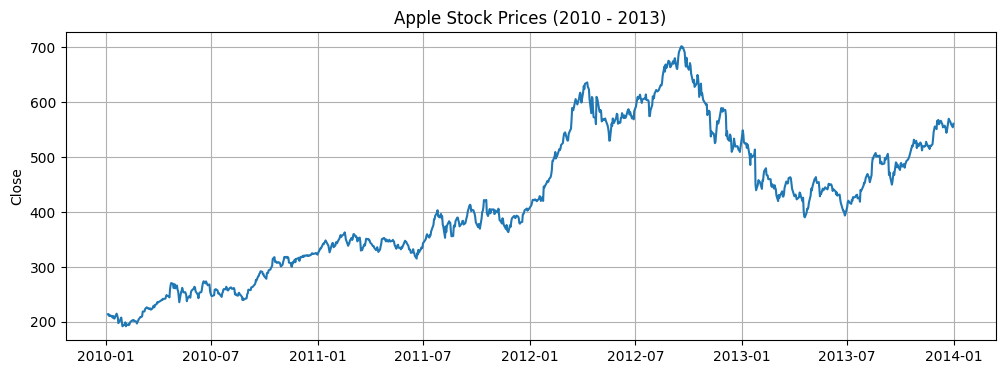

In [7]:
#plot the apple stocks
plt.figure(figsize=(12, 4))
plt.title('Apple Stock Prices (2010 - 2013)')
plt.ylabel('Close')
plt.grid()
plt.plot(df.Close)

## 3. Train test split

In [8]:
#use all the past data, to predict the next 15 days
#input is everything until now...
#output is next 15 days
y = df['Close'].values.astype('float')
train_set = y[:-15]
test_set  = y[-15:]

In [9]:
type(train_set)

numpy.ndarray

## 4. Normalization

We don't do standardization because mean is wrong.  Normalization - 0 to 1.

In [10]:
train_set.shape

(991,)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))

train_set_norm = scaler.fit_transform(train_set.reshape(-1, 1))

In [12]:
train_set_norm.min(), train_set_norm.max()

(-0.9999999999999999, 1.0)

## 5. Prepare train set

In [13]:
#convert np to tensor
train_set_norm = torch.FloatTensor(train_set_norm).view(-1)
train_set_norm.shape

#define window size
ws = 30 #use 30 days in the past to predict the next day

#define function to create training set (ws days -> 1 day)
def create_data(train, ws):
    data = []
    #array to hold the data
    #i runs from 0 to (991 - 30)
    for i in range(train.shape[0] - ws):
        x = train[i:i+ws]       # 30 days in the past
        y = train[i+ws:i+ws+1]  # next day
        data.append((x, y))
    return data

chaky_data = create_data(train_set_norm, ws)


In [14]:
chaky_data[0]

(tensor([0.4468, 0.4213, 0.4432, 0.4581, 0.4729, 0.4824, 0.3997, 0.3819, 0.4066,
         0.4232, 0.4330, 0.4210, 0.4449, 0.4481, 0.4646, 0.4680, 0.4429, 0.4738,
         0.4624, 0.4676, 0.4084, 0.4274, 0.3877, 0.3385, 0.3006, 0.2852, 0.2904,
         0.2663, 0.2842, 0.2806]),
 tensor([0.3055]))

## 6. Neural Network

A variant of RNN called LSTM, which is much more powerful.

### Example

In [58]:
sample, target = chaky_data[0]

In [59]:
sample_reshape = sample.reshape(sample.shape[0], 1, -1)

In [60]:
lstm = nn.LSTM(1, 50)

In [61]:
out, hidden = lstm(sample_reshape)

In [62]:
out.shape 

torch.Size([30, 1, 50])

In [63]:
hidden[0].shape

torch.Size([1, 1, 50])

In [56]:
# assert out[-1] == hidden[0]

In [64]:
out = out.view(len(out), -1)
out.shape

torch.Size([30, 50])

In [65]:
linear_layer = nn.Linear(50, 1)

In [66]:
out = linear_layer(out)
out.shape

torch.Size([30, 1])

### Network

In [67]:
class chaky_RNN(nn.Module):
    def __init__(self, input_s = 1, hs = 50, output_size = 1):
        super().__init__()
        self.hs = hs
        self.lstm = nn.LSTM(input_s, hs)  #LSTM will automatically create W(s) for us
        self.linear = nn.Linear(hs, output_size)  #take output of LSTM, project to prediction
        
    def forward(self, input_):
        out = self.lstm(input_.reshape(input_.shape[0], 1, -1)) #30, 1, 1
        out = self.linear(out.view(len(input_), -1))  #30, 50
        return out[-1]

In [68]:
torch.manual_seed(999)
model = chaky_RNN()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)